In [2]:
%matplotlib inline

import sys
sys.path.append("./mw_csi_pkg/csi")

import torch
# from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor

from torch2trt import torch2trt


# from csi_utils import get_weight_matrix_linspace

In [3]:
from mw_csi_pkg.csi.csi_utils import compute_csi
from mw_csi_pkg.csi.csi_utils import get_discrete_csi
# from mw_csi_pkg.csi.csi_utils import compute_failure_mode
from mw_csi_pkg.utils.main_utils import convert_tensors_to_numpy_arrays


/mnt/ssd/csi_pipeline/test-orin-py/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import gi
import logging
import cv2 as cv
import numpy as np

gi.require_version("Gst", "1.0")
gi.require_version("GstBase", "1.0")

from gi.repository import Gst
from gi.repository import GLib
from gi.repository import GstBase
from gi.repository import GObject

import yaml
from matplotlib.colors import ListedColormap

from mw_csi_pkg.inference.inference import Inference
from mw_csi_pkg.visualization.plotting_utils import put_csi_text
# from mw_csi_pkg.visualization.plotting_utils import blended_road_pred
# from mw_csi_pkg.visualization.plotting_utils import put_failure_mode_text
from mw_csi_pkg.visualization.plotting_utils import blended_garbage_and_road
# from mw_csi_pkg.visualization.plotting_utils import blended_failure_mode_colored
# from mw_csi_pkg.visualization.plotting_utils import blend_failure_mode_and_street

In [5]:
# load configurations from YAML file
CONFIG_FILE = "./config/csi_config.yaml"
with open(CONFIG_FILE, "r") as stream:
    config = yaml.safe_load(stream)

# define colors for each label
class_labels = config["GARBAGE_MODEL"]["CLASS_LABELS"]
colors = [[68, 1, 84], [32, 144, 140], [253, 231, 36]]
label_colors = {k: v for k, (v, _) in enumerate(zip(colors, class_labels))}

# create a colormap using the defined colors
cmap = ListedColormap([np.array(color) / 255.0 for color in label_colors.values()])

In [6]:
base_garbage_model_path = "/media/ganindu/CONFIG/base_models/unserialised/base_models_fp32/mw_garbage_checkpoint.pt"
base_road_model_path = "/media/ganindu/CONFIG/base_models/unserialised/base_models_fp32/mw_road_checkpoint.pt"

In [12]:
# creating an inference object
inference = Inference(config)

# perform inference on the input image
camera = "front"
image_path = "./test_images/4.png"
bgr_image = cv.imread(image_path)

In [8]:


road_model = inference.road_model
garbage_model = inference.garbage_model

device = inference.device
print(f"Using device: {device}")

Using device: cuda


In [9]:
krn_size = 3
kernel = torch.zeros(size=(1, 1, krn_size, krn_size), dtype=torch.float32, requires_grad=False)
kernel[:, :, (krn_size // 2) + 1, (krn_size // 2) + 1] = 1.
if torch.cuda.is_available():
    kernel = kernel.cuda()

In [14]:

def make_sample_input_for_trt():
    # Create a sample input: a numpy array with shape (1820, 1920, 3) with float values
    sample_input = np.ones((1080, 1920, 3), dtype=np.float32)
    sample_input_processed = inference.transform(image=sample_input)["image"].unsqueeze(0).to(device)
    return sample_input_processed

In [15]:
frame = cv.cvtColor(src=cv.imread(image_path), code=cv.COLOR_BGR2RGB)
frame = frame.astype(dtype=np.float32) / 255.0
frame_t = inference.transform(image=frame)["image"].unsqueeze(0).to(device)

TypeError: Compose.__call__() got an unexpected keyword argument 'image'

In [11]:
# perform inference on the input image
road_model_cuda = road_model.eval().cuda()
garbage_model_cuda = garbage_model.eval().cuda()

road_model_sample_input = make_sample_input_for_trt()
road_model_trt = torch2trt(road_model_cuda, [road_model_sample_input], fp16_mode=True)

garbage_model_sample_input = make_sample_input_for_trt()
garbage_model_trt = torch2trt(garbage_model_cuda, [garbage_model_sample_input], fp16_mode=True)

In [12]:
torch.save(road_model_trt.state_dict(), "models/road_model_trt_fp16.pth")
torch.save(garbage_model_trt.state_dict(), "models/garbage_model_trt_fp16.pth")

In [13]:
from torch2trt import TRTModule

road_model_trt_imported = TRTModule()
garbage_model_trt_imported = TRTModule()

road_model_trt_imported.load_state_dict(torch.load("./models/road_model_trt_fp16.pth", map_location=device))
garbage_model_trt_imported.load_state_dict(torch.load("./models/garbage_model_trt_fp16.pth", map_location=device))

<All keys matched successfully>

In [20]:

road_logits = road_model_trt_imported(frame_t)
garbage_logits = garbage_model_trt_imported(frame_t)

In [21]:
road_model_cuda = road_model.to(device)
garbage_model_cuda = garbage_model.to(device)

In [30]:
percentage_dirty_road=config["PERCENTAGE_DIRTY_ROAD"]
garbage_type_coeffs=config["GARBAGE_TYPE_COEFFICIENTS"]
f_mode_th=config["F_MODE_TH"]
padding = 1
stride = 4

with torch.no_grad():
    garbage_logits = garbage_model_trt_imported(frame_t)
    road_logits = road_model_trt_imported(frame_t)

    road_pred = torch.argmax(torch.softmax(road_logits, dim=1), dim=1)
    garbage_pred = torch.argmax(torch.softmax(garbage_logits, dim=1), dim=1)

    relative_csi = None
    absolute_csi = None
    discrete_csi = None
    ratios_street_dict = None
    colored_failure_mode = None
    percentage_th = None
    np_road_pred = None
    np_garbage_pred = None

    # if the road model predicts correctly the road | FRONT CAM ONLY
    if torch.sum(road_pred) > 0:
        relative_csi, absolute_csi = compute_csi(road_mask=road_pred, garbage_mask=garbage_pred,
                                                    kernel=kernel, padding=padding, stride=stride,
                                                    percentage_dirty_road=percentage_dirty_road,
                                                    garbage_type_coeffs=garbage_type_coeffs, debug=False)
        levels = inference.front_levels
        discrete_csi, _ = get_discrete_csi(continuos_csi=relative_csi, levels=levels)

        # convert tensor predictions to numpy array
        np_road_pred, np_garbage_pred = convert_tensors_to_numpy_arrays(src1=road_pred, src2=garbage_pred,
                                                                                resize=True, config=config)
        

    else:
        relative_csi = -0.01  # NaN
        absolute_csi = -0.01  # NaN
        discrete_csi = -0.01  # NaN
        ratios_street_dict = {"left": -0.01, "center": -0.01, "right": -0.01}  # NaN
        colored_failure_mode = np.zeros(shape=(config["IMG_H"], config["IMG_W"], 3), dtype=np.uint8)
        percentage_th = -0.01  # NaN
        np_road_pred = np.zeros(shape=(config["IMG_H"], config["IMG_W"]), dtype=np.uint8)
        np_garbage_pred = np.zeros(shape=(config["IMG_H"], config["IMG_W"]), dtype=np.uint8)


In [32]:
rgb = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)

# rgb = cv.resize(src=rgb, dsize=(config["IMG_W_VIS_RESIZE"], config["IMG_H_VIS_RESIZE"]), interpolation=cv.INTER_LINEAR)



rgb_image = cv.resize(src=rgb, dsize=(config["IMG_W_VIS_RESIZE"], config["IMG_H_VIS_RESIZE"]), interpolation=cv.INTER_LINEAR)
composite_image = blended_garbage_and_road(frame=rgb_image, np_road_pred=np_road_pred, np_garbage_pred=np_garbage_pred, alpha=config["ALPHA"])

composite_image_rgba = cv.cvtColor(composite_image, cv.COLOR_RGB2RGBA)
composite_image_rgba = cv.resize(src=composite_image_rgba, dsize=(config["IMG_W"], config["IMG_H"]), interpolation=cv.INTER_LINEAR)
composite_image_rgba = put_csi_text(img=composite_image_rgba, relative_csi=relative_csi, discrete_csi=discrete_csi)



# composite_image = blended_garbage_and_road(frame=rgb_image, np_road_pred=np_road_pred, np_garbage_pred=np_garbage_pred, alpha=config["ALPHA"])
    

print(f"np_road_red_shape: {np_road_pred.shape}, np_garbage_pred_shape: {np_garbage_pred.shape}, rgb_shape: {rgb.shape}")


# composite_image = blended_garbage_and_road(frame=rgb, np_road_pred=np_road_pred, np_garbage_pred=np_garbage_pred, alpha=config["ALPHA"])


# dst_image = put_csi_text(img=composite_image, relative_csi=relative_csi, discrete_csi=discrete_csi)


np_road_red_shape: (270, 480), np_garbage_pred_shape: (270, 480), rgb_shape: (1080, 1920, 3)


(-0.5, 1919.5, 1079.5, -0.5)

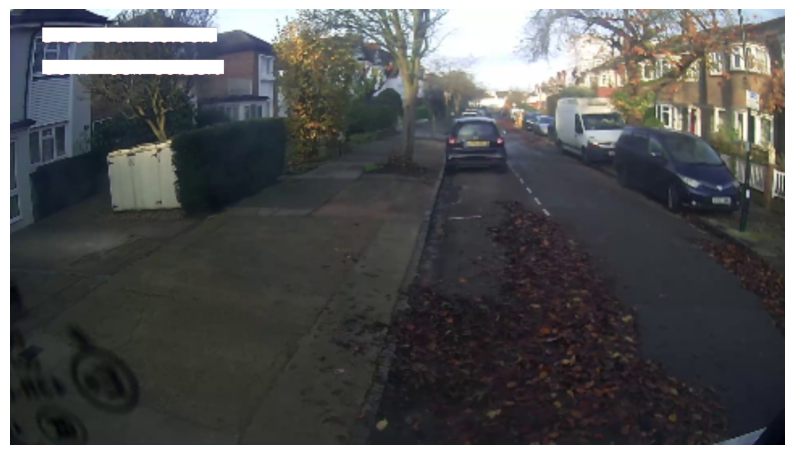

In [33]:
# show the image with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(composite_image_rgba)
plt.axis("off")

In [26]:
percentage_dirty_road=config["PERCENTAGE_DIRTY_ROAD"]
garbage_type_coeffs=config["GARBAGE_TYPE_COEFFICIENTS"]
f_mode_th=config["F_MODE_TH"]
padding = 1
stride = 4

garbage_logits = garbage_model_trt(frame_t)
road_logits = road_model_trt(frame_t)

with torch.no_grad():

    road_pred = torch.argmax(torch.softmax(road_logits, dim=1), dim=1)
    garbage_pred = torch.argmax(torch.softmax(garbage_logits, dim=1), dim=1)

    relative_csi = None
    absolute_csi = None
    discrete_csi = None
    ratios_street_dict = None
    colored_failure_mode = None
    percentage_th = None
    np_road_pred = None
    np_garbage_pred = None

    # if the road model predicts correctly the road | FRONT CAM ONLY
    if torch.sum(road_pred) > 0:
        relative_csi, absolute_csi = compute_csi(road_mask=road_pred, garbage_mask=garbage_pred,
                                                    kernel=kernel, padding=padding, stride=stride,
                                                    percentage_dirty_road=percentage_dirty_road,
                                                    garbage_type_coeffs=garbage_type_coeffs, debug=False)
        levels = inference.front_levels
        discrete_csi, _ = get_discrete_csi(continuos_csi=relative_csi, levels=levels)

        # convert tensor predictions to numpy array
        np_road_pred, np_garbage_pred = convert_tensors_to_numpy_arrays(src1=road_pred, src2=garbage_pred,
                                                                                original_size=True, config=config)
        

    else:
        relative_csi = -0.01  # NaN
        absolute_csi = -0.01  # NaN
        discrete_csi = -0.01  # NaN
        ratios_street_dict = {"left": -0.01, "center": -0.01, "right": -0.01}  # NaN
        colored_failure_mode = np.zeros(shape=(config["IMG_H"], config["IMG_W"], 3), dtype=np.uint8)
        percentage_th = -0.01  # NaN
        np_road_pred = np.zeros(shape=(config["IMG_H"], config["IMG_W"]), dtype=np.uint8)
        np_garbage_pred = np.zeros(shape=(config["IMG_H"], config["IMG_W"]), dtype=np.uint8)


TypeError: convert_tensors_to_numpy_arrays() got an unexpected keyword argument 'original_size'

In [ ]:
rgb = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)

composite_image = blended_garbage_and_road(frame=rgb, np_road_pred=np_road_pred,
                                                       np_garbage_pred=np_garbage_pred,
                                                       alpha=config["ALPHA"])

dst_image = put_csi_text(img=composite_image, relative_csi=relative_csi, discrete_csi=discrete_csi)

# show the image with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(dst_image)
plt.axis("off")
